In [142]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, roc_curve, auc, mean_squared_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, make_scorer
from sklearn.metrics import roc_auc_score
from sklearn.datasets import make_classification
%config IPCompleter.greedy=True
from sklearn.linear_model import LogisticRegression, Ridge, Lasso, LassoCV, RidgeCV, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, RandomForestRegressor
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer
import scipy
sns.set_style("whitegrid")
sns.set(rc={'figure.figsize': (12, 6)})
import warnings
warnings.filterwarnings('ignore')

In [143]:
df = pd.read_csv("https://raw.githubusercontent.com/Yorko/mlcourse.ai/master/data/bikes_rent.csv")

In [144]:
df.head()

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


<AxesSubplot:xlabel='season', ylabel='cnt'>

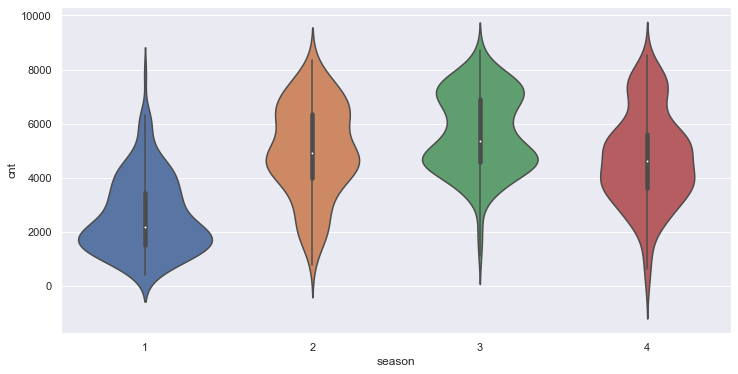

In [145]:
sns.violinplot(df["season"], df["cnt"])

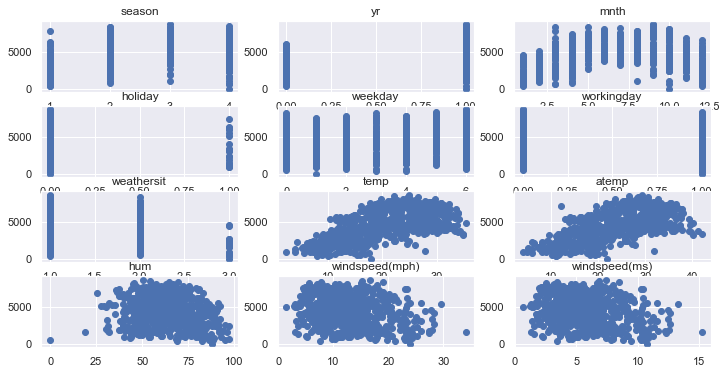

In [146]:
for i, col in enumerate(df.columns[:-1]):
    plt.subplot(4, 3, i + 1)
    plt.scatter(df[col], df["cnt"])
    plt.title(col)

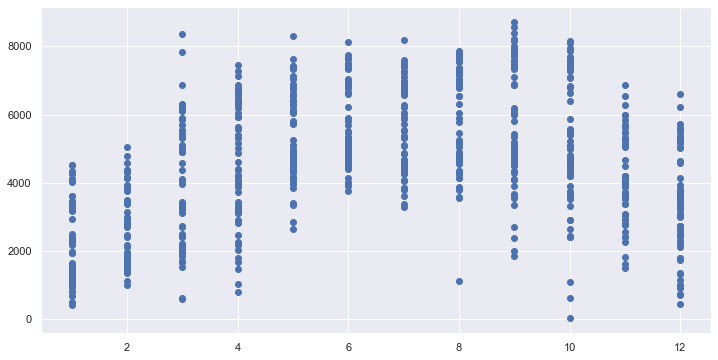

In [147]:
plt.scatter(df.mnth, df.cnt)

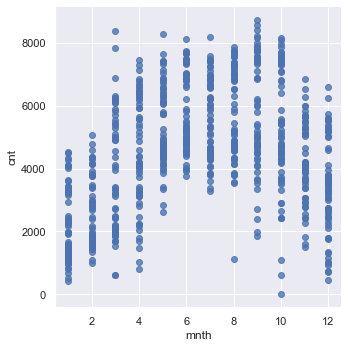

In [148]:
sns.lmplot(x="mnth", y="cnt", data=df, fit_reg=False)

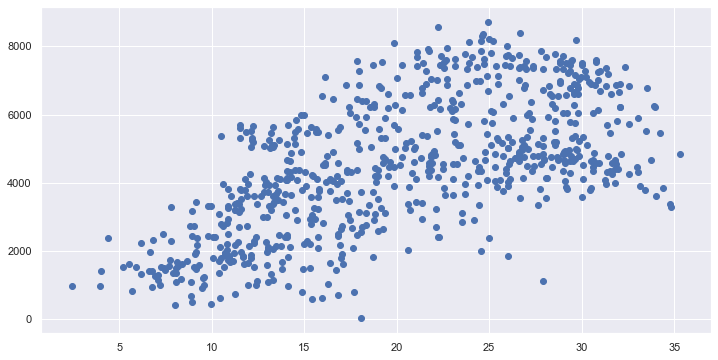

In [149]:
plt.scatter(df.temp, df.cnt)

In [150]:
linreg = LinearRegression()
lasso = Lasso(random_state=17)
ridge = Ridge(random_state=17)
lasso_cv = LassoCV(random_state=17)
ridge_cv = RidgeCV()

In [151]:
X, y = df.drop("cnt", axis=1).values, df["cnt"].values

In [152]:
train_part_size = int(.7 * X.shape[0])

X_train, X_valid = X[:train_part_size, :], X[train_part_size:, :]
y_train, y_valid = y[:train_part_size], y[train_part_size:]

In [153]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_valid_scaled = scaler.transform(X_valid)

In [154]:
linreg.fit(X_train_scaled, y_train)

LinearRegression()

In [155]:
np.sqrt(mean_squared_error(y_valid, linreg.predict(X_valid_scaled)))

1121.795457438696

<AxesSubplot:>

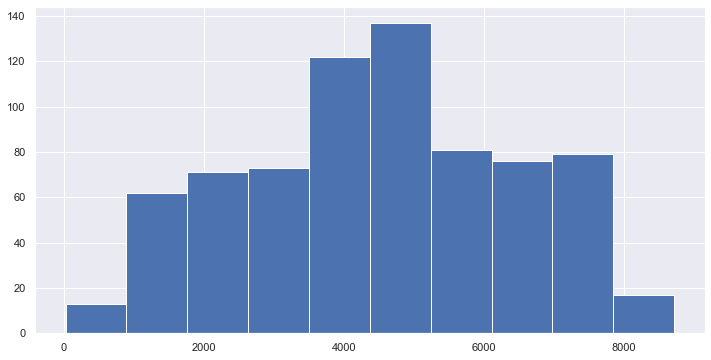

In [156]:
df["cnt"].hist()

In [157]:
linreg.coef_

array([ 4.04858542e+02,  9.54069773e+02,  3.08090550e+01, -6.75744827e+01,
        1.03711794e+02,  1.47027057e+01, -2.93816859e+02,  6.24779238e+01,
        8.91179537e+02, -1.58976676e+02, -3.05095629e+12,  3.05095629e+12])

In [158]:
pd.DataFrame(linreg.coef_, df.columns[:-1], columns=["coef"]).sort_values(by="coef", ascending=False)

,coef
windspeed(ms),3.050956e+12
yr,9.540698e+02
atemp,8.911795e+02
season,4.048585e+02
weekday,1.037118e+02
temp,6.247792e+01
mnth,3.080906e+01
workingday,1.470271e+01
holiday,-6.757448e+01
hum,-1.589767e+02


In [161]:
def train_validate_report(model, X_train_scaled, y_train, X_valid_scaled,
                          y_valid, feature_names, forest=False):
    model.fit(X_train_scaled, y_train)
    print(f"MSE = {np.sqrt(mean_squared_error(y_valid, model.predict(X_valid_scaled)))}")
    print("Model coefficients:")
    coef = model.feature_importances_ if forest else model.coef_
    coef_name = "Importance" if forest else "Coef"
    print(pd.DataFrame(coef, feature_names, columns=[coef_name])
          .sort_values(by=coef_name, ascending=False))

In [162]:
train_validate_report(lasso_cv, X_train_scaled, y_train, X_valid_scaled, y_valid,
                      feature_names=df.columns[:-1])

MSE = 1120.7436606195301
Model coefficients:
                      Coef
yr              951.135002
atemp           883.344030
season          403.009581
weekday         101.892690
temp             69.238981
mnth             28.608639
workingday       13.478682
windspeed(ms)    -0.000000
holiday         -66.360460
hum            -156.248289
windspeed(mph) -186.267734
weathersit     -293.016582


In [163]:
train_validate_report(ridge, X_train_scaled, y_train, X_valid_scaled, y_valid,
                      feature_names=df.columns[:-1])

MSE = 1119.5605202108375
Model coefficients:
                      Coef
yr              954.075878
atemp           730.747340
season          400.114172
temp            221.406072
weekday         103.198680
mnth             34.687740
workingday       15.334339
holiday         -69.046689
windspeed(ms)   -95.819798
windspeed(mph)  -95.819798
hum            -157.702520
weathersit     -293.899386


In [164]:
train_validate_report(ridge_cv, X_train_scaled, y_train, X_valid_scaled, y_valid,
                      feature_names=df.columns[:-1])

MSE = 1118.903543321992
Model coefficients:
                      Coef
yr              934.401985
atemp           534.482125
temp            410.485392
season          375.585733
weekday         100.838401
mnth             48.142392
workingday       16.165284
holiday         -70.019251
windspeed(ms)   -97.770430
windspeed(mph)  -97.770430
hum            -155.174377
weathersit     -291.035853


In [165]:
forest = RandomForestRegressor(random_state=17, n_estimators=500)

In [166]:
train_validate_report(forest, X_train, y_train, X_valid, y_valid,
                      feature_names=df.columns[:-1], forest=True)

MSE = 1046.9607717751937
Model coefficients:
                Importance
temp              0.298609
atemp             0.243309
yr                0.199314
hum               0.070565
season            0.062295
weathersit        0.030535
mnth              0.027786
windspeed(mph)    0.020349
weekday           0.019819
windspeed(ms)     0.019613
workingday        0.005191
holiday           0.002615
